CHAÎNE DE TRANSMISSION HALF DUPLEX : ÉMISSION, RÉCEPTION AVEC BRUIT, ACK

--- PHASE 1 : ÉMISSION DU MESSAGE ---
=== ÉMISSION : Conversion ASCII ===
Texte en binaire : [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0]
=== ÉMISSION : CRC ===
Résultat CRC : [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0]
=== ÉMISSION : TRAME ===
Octet protocole : [1, 1, 0, 0, 0, 0, 1, 1]
Fanion de début : [1, 1, 1, 1, 1, 1, 1, 1]
Fanion de fin   : [0, 0, 0, 0, 0, 0, 0, 0]
Trame complète  : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,

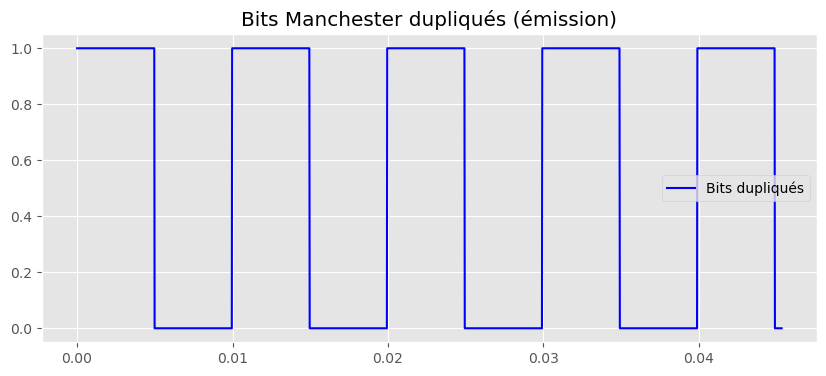

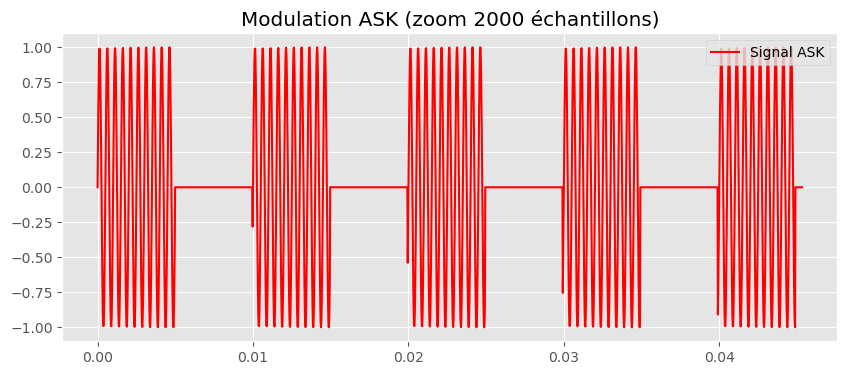

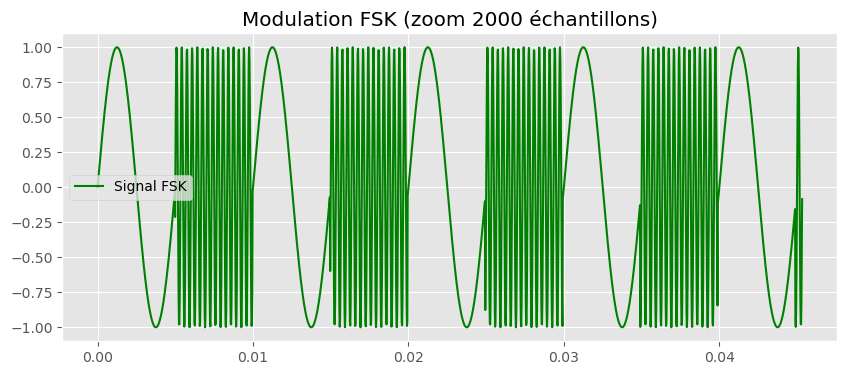


--- PHASE 2 : RÉCEPTION DU MESSAGE (avec bruit) ---
=== RÉCEPTION : Lecture CSV ===
ASK (extrait) avant bruit : [0.       0.281111 0.539551 0.754476 0.908553 0.989355 0.990367 0.911506
 0.759132 0.545535] ...
FSK (extrait) avant bruit : [0.       0.028491 0.056959 0.085381 0.113734 0.141994 0.170139 0.198146
 0.225992 0.253655] ...
=== RÉCEPTION : Signal bruité ===
ASK (extrait) après bruit : [0.02577872 0.29307043 0.54988294 0.74888836 0.93298691 0.98104496
 0.96329213 0.90121403 0.74998891 0.5453384 ] ...
FSK (extrait) après bruit : [0.01670099 0.03661226 0.09308197 0.08390943 0.10731773 0.10644916
 0.15992205 0.21838416 0.21627774 0.26031558] ...


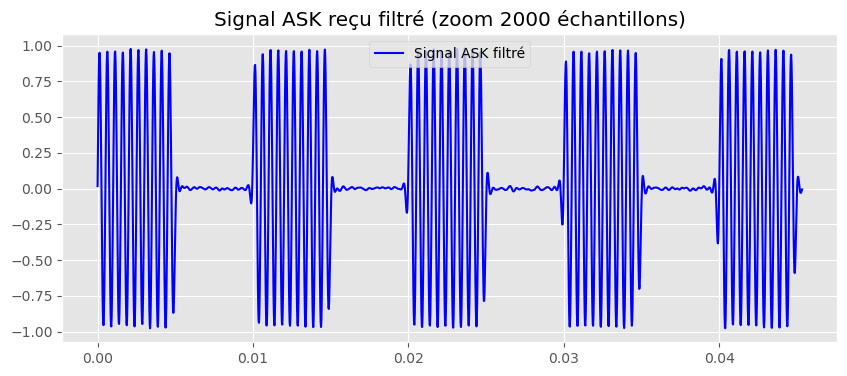

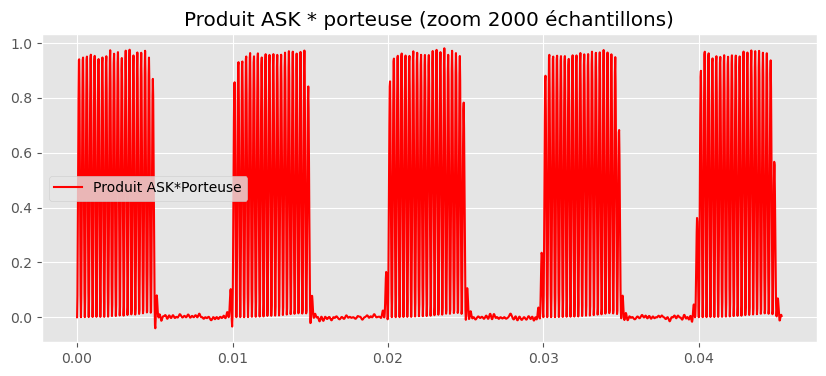

=== RÉCEPTION : Démodulation ===
Bits démodulés ASK (extrait) : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ...
Erreur de décodage Manchester (valeurs égales) à l'index 0
Erreur de décodage Manchester (valeurs égales) à l'index 1
Erreur de décodage Manchester (valeurs égales) à l'index 2
Erreur de décodage Manchester (valeurs égales) à l'index 3
Erreur de décodage Manchester (valeurs égales) à l'index 4
Erreur de décodage Manchester (valeurs égales) à l'index 5
Erreur de décodage Manchester (valeurs égales) à l'index 6
Erreur de décodage Manchester (valeurs égales) à l'index 7
Erreur de décodage Manchester (valeurs égales) à l'index 8
Erreur de décodage Manchester (valeurs égales) à l'index 9
Erreur de décodage Manchester (valeurs égales) à l'index 11
Erreur de décodage Manchester (valeurs égales) à l'index 12
Erreur de décodage Manchester (valeurs égales) à l'index 13
Erreur de d

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

plt.style.use('ggplot')

###############################################################################
#                   PARAMÈTRES GLOBAUX
###############################################################################
Fe   = 44100        # Fréquence d'échantillonnage
baud = 200          # Débit binaire
Ns   = int(Fe/baud) # Nb d'échantillons par bit (~220)
Fp_ASK = 2000
fp1    = 200
fp2    = 3000

###############################################################################
#                   ÉMISSION : CRC, TRAME, MANCHESTER, MODULATION
###############################################################################

def crcemission(bits):
    """
    Calcule et ajoute 4 bits de CRC pour chaque octet (diviseur '1001').
    """
    diviseur = int("1001", 2)
    resultat_crc = []
    local_bits = bits[:]
    while len(local_bits) >= 8:
        donne_str = ''.join(map(str, local_bits[:8]))
        local_bits = local_bits[8:]
        # Ajout de 4 zéros
        div_str = donne_str + "0000"
        div_int = int(div_str, 2)
        _, reste = divmod(div_int, diviseur)
        # On remet l'octet et le reste
        resultat_crc.extend(map(int, donne_str))
        resultat_crc.extend(map(int, format(reste, '04b')))
    return resultat_crc

def trame_emission(bits, type_fichier="txt"):
    """
    Construit la trame :
      - fanion de début : 11111111
      - octet de protocole (ex : 11000011 pour txt)
      - bits + CRC
      - fanion de fin : 00000000
    """
    fanion_debut = [1]*8
    fanion_fin   = [0]*8
    # Ex : protocole "txt" = [1,1,0,0,0,0,1,1]
    prot_txt = [1,1,0,0,0,0,1,1] if type_fichier=="txt" else [0,0,0,0,0,0,0,0]

    return fanion_debut + prot_txt + bits + fanion_fin

def Manchester_encode(bits):
    """
    1 -> (1,0)
    0 -> (0,1)
    """
    code = []
    for b in bits:
        if b == 1:
            code.extend([1,0])
        else:
            code.extend([0,1])
    return code

def modulation_ASK_FSK(bits_manchester, filename_prefix="Message"):
    """
    Génère 2 signaux (ASK, FSK), enregistre dans 2 CSV, lit en audio.
    bits_manchester : liste binaire codée Manchester
    filename_prefix : "Message" ou "ACK", etc. pour distinguer les fichiers CSV.
    """
    bits_dupliques = np.repeat(bits_manchester, Ns)
    N = len(bits_dupliques)
    t = np.arange(N)/Fe

    # Porteuse ASK
    porteuse = np.sin(2*np.pi*Fp_ASK*t)
    ASK = bits_dupliques * porteuse

    # FSK
    s1 = np.sin(2*np.pi*fp1*t)
    s2 = np.sin(2*np.pi*fp2*t)
    FSK = np.where(bits_dupliques==1, s1, s2)

    # Sauvegarde
    ask_file = f"{filename_prefix}_ASK.csv"
    fsk_file = f"{filename_prefix}_FSK.csv"
    np.savetxt(ask_file, ASK, fmt='%.6f', delimiter=',')
    np.savetxt(fsk_file, FSK, fmt='%.6f', delimiter=',')

    # Lecture audio
    sd.play(ASK, Fe)
    sd.wait()
    sd.play(FSK, Fe)
    sd.wait()

    # Graphiques (optionnel, simplifié ici)
    plt.figure(figsize=(10,3))
    plt.plot(t[:2000], bits_dupliques[:2000], color='blue', label='Bits dupliqués (Manchester)')
    plt.title(f"{filename_prefix}: bits (zoom 2000)")
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(10,3))
    plt.plot(t[:2000], ASK[:2000], color='red', label='ASK')
    plt.title(f"{filename_prefix}: ASK (zoom 2000)")
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(10,3))
    plt.plot(t[:2000], FSK[:2000], color='green', label='FSK')
    plt.title(f"{filename_prefix}: FSK (zoom 2000)")
    plt.legend()
    plt.grid(True)

    plt.show()

###############################################################################
#                     RÉCEPTION : DÉMODULATION, DÉCODAGE
###############################################################################

def demodulation_ASK_FSK(filename_prefix="Message"):
    """
    Lit 2 CSV (ASK et FSK), démodule la voie ASK.
    """
    ask_file = f"{filename_prefix}_ASK.csv"
    fsk_file = f"{filename_prefix}_FSK.csv"

    ASK_signal = np.genfromtxt(ask_file, delimiter=',')
    FSK_signal = np.genfromtxt(fsk_file, delimiter=',')

    N = len(ASK_signal)
    t = np.arange(N)/Fe
    # Démod ASK
    porteuse = np.sin(2*np.pi*Fp_ASK*t)
    produit  = ASK_signal * porteuse
    bits = []
    for i in range(0, N, Ns):
        portion = produit[i:i+Ns]
        val = np.trapz(portion)
        bits.append(1 if val>0 else 0)

    # (On pourrait afficher le FSK pour info, mais la voie FSK n'est pas
    #  strictement utile si on ne l'utilise pas.)
    return bits

def Manchester_decode(bits):
    """
    Récupère 1 bit sur chaque paire (1,0) -> 1, (0,1) -> 0
    """
    decode = []
    for i in range(0, len(bits), 2):
        b1 = bits[i]
        b2 = bits[i+1]
        if (b1,b2) == (1,0):
            decode.append(1)
        elif (b1,b2) == (0,1):
            decode.append(0)
        # Sinon motif inconnu
    return decode

def trame_reception(bits):
    """
    Extrait fanion début (11111111), fanion fin (00000000), octet protocole, data+CRC
    Retourne data_crc, type_fichier
    """
    if len(bits) < 16:
        return None, None
    fanion_debut = bits[:8]
    fanion_fin   = bits[-8:]
    core = bits[8:-8]

    if fanion_debut != [1]*8 or fanion_fin != [0]*8:
        return None, None

    if len(core)<8:
        return None, None

    protocole = core[:8]
    data_crc  = core[8:]
    type_fic = "txt" if protocole == [1,1,0,0,0,0,1,1] else "?"
    return data_crc, type_fic

def crcreception(bits):
    """
    Lit par blocs de 12 bits : 8 data + 4 CRC
    Diviseur '1001' (9).
    """
    diviseur = int("1001", 2)
    idx = 0
    data_res = []
    integrite_ok = True
    while idx+12<=len(bits):
        bloc = bits[idx:idx+12]
        idx += 12
        data_8 = bloc[:8]
        reste_4= bloc[8:]
        # Recalc
        data_str = ''.join(map(str, data_8))
        data_plus_0000 = data_str+"0000"
        data_dec = int(data_plus_0000,2)
        reste_calc = data_dec % diviseur
        reste_str  = format(reste_calc, '04b')
        recu_str   = ''.join(map(str, reste_4))
        if reste_str!=recu_str:
            integrite_ok=False
        data_res.extend(data_8)
    if integrite_ok:
        return data_res
    else:
        return None

def ASCII_decode(bits, type_fic):
    """
    8 bits -> 1 char, reconstruit la chaîne ASCII
    """
    if type_fic!="txt" or not bits:
        return "[Protocole inconnu ou bits vides]"
    chaine = ""
    for i in range(0, len(bits),8):
        octet = bits[i:i+8]
        if len(octet)<8:
            break
        val = int(''.join(map(str, octet)),2)
        chaine+=chr(val)
    return chaine

###############################################################################
#                   HALF-DUPLEX AVEC ACK
###############################################################################

def send_message_and_receive_ack():
    """
    1) L'utilisateur saisit un message
    2) On émet (CRC, trame, Manchester, ASK/FSK)
    3) Le "Receiver" démodule, décode, reconstitue ASCII
    4) S'il n'y a pas d'erreur => le Receiver émet un ACK (message "OK" par ex.)
    5) Le "Sender" reçoit cet ACK
    """
    #### ÉMISSION DU MESSAGE ####
    print("=== PHASE 1 : ÉMISSION DU MESSAGE ===")
    # Saisie
    texte = ""
    while not texte:
        texte = input("Saisissez votre message :\n")

    # ASCII -> bits
    bits_texte = []
    for c in texte:
        bits_texte.extend(int(x) for x in format(ord(c),'08b'))

    # CRC
    bits_crc = crcemission(bits_texte)
    # Trame
    bits_trame = trame_emission(bits_crc, "txt")
    # Manchester
    bits_manch = Manchester_encode(bits_trame)
    # Modulation
    modulation_ASK_FSK(bits_manch, filename_prefix="Message")

    #### RÉCEPTION DU MESSAGE ####
    print("\n=== PHASE 2 : RÉCEPTION DU MESSAGE ===")
    ask_bits = demodulation_ASK_FSK(filename_prefix="Message")
    decode_manch = Manchester_decode(ask_bits)
    data_crc, type_fic = trame_reception(decode_manch)
    if data_crc is None or type_fic is None:
        print("Trame invalide, pas d'ACK.")
        return
    data_ok = crcreception(data_crc)
    if data_ok is None:
        print("CRC invalide, pas d'ACK.")
        return
    message_final = ASCII_decode(data_ok, type_fic)
    print("Message final reçu :", message_final)

    #### SI OK, ON ÉMET UN ACK ####
    print("\n=== PHASE 3 : ÉMISSION D'UN ACK (HALF-DUPLEX) ===")
    ack_str = "OK"  # petit message d'accusé de réception
    bits_ack = []
    for c in ack_str:
        bits_ack.extend(int(x) for x in format(ord(c),'08b'))
    # on refait la chaîne CRC + trame + Manchester + modulation
    ack_crc = crcemission(bits_ack)
    ack_trame = trame_emission(ack_crc, "txt")  # on peut dire "txt" ou "ack"
    ack_manch = Manchester_encode(ack_trame)
    modulation_ASK_FSK(ack_manch, filename_prefix="ACK")

    #### RÉCEPTION DE L'ACK ####
    print("\n=== PHASE 4 : RÉCEPTION DE L'ACK ===")
    ack_bits_received = demodulation_ASK_FSK(filename_prefix="ACK")
    ack_manch_dec = Manchester_decode(ack_bits_received)
    ack_data_crc, ack_type = trame_reception(ack_manch_dec)
    if ack_data_crc is None or ack_type is None:
        print("ACK invalid.")
        return
    ack_data_ok = crcreception(ack_data_crc)
    if ack_data_ok is None:
        print("ACK corrompu.")
        return
    ack_message = ASCII_decode(ack_data_ok, ack_type)
    print("ACK final reçu :", ack_message)

    print("\n=== Liaison half-duplex terminée ===")

###############################################################################
#                          PROGRAMME PRINCIPAL
###############################################################################

if __name__=="__main__":
    print("""
-------------------------------------
     DEMO HALF-DUPLEX AVEC ACK
-------------------------------------
""")
    send_message_and_receive_ack()
